# Idee 1: The lazy mans way

Trainiere 10 VAE, jeweils mit den Samples einer Klasse von MNIST. Wir haben dann 10 VAE, jeder spezialisiert auf die Generierung einer Zahl. Immer wenn wir eine Zahl generieren müssen, benutzen wir dafür den jeweiligen speizialisierten VAE.

# Idee 2: Wie auf dem Zettel vorgeschlagen mithilfe von Conditional Variational Autencodern (CVAE)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np
import multiprocessing 

In [2]:
if torch.cuda.is_available():
    device = "cuda"
    print("Training on gpu")
else:
    device = "cpu"
    print("Training on cpu")

Training on gpu


In [3]:
class CCVAE(nn.Module):
    """ Conditional convolutional variational autoencoder.
    """
    def __init__(self, input_channels, lat_dim, device):
        super().__init__()
        self.conv1_ds = nn.Conv2d(input_channels, 32, kernel_size=(3, 3), stride=(2,2), padding=1)
        self.conv2_ds = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.dense_enc_mean = nn.Linear(7 * 7 * 64, lat_dim)
        self.dense_enc_std = nn.Linear(7 * 7 *64, lat_dim)
        self.dense_dec = nn.Linear(lat_dim, 7 * 7 * 32)
        self.conv2_us = nn.ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.conv1_us = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.conv0_us = nn.ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.lat_dim = lat_dim
        self.device = device
        
    def encode(self, x):
        x = self.conv1_ds(x)
        x = nn.functional.relu(x)
        x = self.conv2_ds(x)
        x = nn.functional.relu(x)
        x = torch.flatten(x, 1)
        mean, std = self.dense_enc_mean(x), self.dense_enc_std(x)
        return mean, std
        
    def decode(self, x):
        x = self.dense_dec(x)
        x = nn.functional.relu(x)
        x = torch.reshape(x, (x.shape[0], 32, 7, 7))
        x = self.conv2_us(x)
        x = nn.functional.relu(x)
        x = self.conv1_us(x)
        x = nn.functional.relu(x)
        x = self.conv0_us(x)
        # trick to make sure all outputs are in range [0, 1]
        x = torch.sigmoid(x)
        return x
        
    def forward(self, x):
        mean, std = self.encode(x)
        latent = self.reparameterize(mean, std)
        out = self.decode(latent)
        return out, mean, std
        
    def reparameterize(self, mean, std):
        eps = torch.randn_like(mean).to(self.device)
        return eps * std + mean

    def generate(self, num_samples):
        with torch.no_grad():
            eps = torch.randn((num_samples, self.lat_dim)).to(self.device)
            return self.decode(eps)
        
def kl_divergence(mean, std):
    variance = std.pow(2)
    inner = mean.pow(2) + variance - 1 - torch.log(variance)
    return (1/2) * torch.mean(inner)

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

dataset = torch.utils.data.ConcatDataset((trainset, testset))
ds_loader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                         shuffle=True, num_workers=multiprocessing.cpu_count())

In [4]:
generator = CCVAE(1, 2, device).to(device)

In [5]:
num_epochs = 10
bce_loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

rec_losses = []
kl_losses = []
generator.train()
for epoch in range(1, num_epochs + 1):
    running_rec_loss = 0
    running_kl_loss = 0
    iterations = 0
    for x, _ in ds_loader:
        x = x.to(device)
        optimizer.zero_grad()
        reconstruction, mean, std = generator(x)
        reconstruction = reconstruction.view(x.shape[0], -1)
        x = x.view(x.shape[0], -1)
        reconstruction_loss = bce_loss(reconstruction, x)
        kl_loss = 0.01 * kl_divergence(mean, std)
        loss = reconstruction_loss + kl_loss
        loss.backward()
        optimizer.step()
        running_rec_loss += loss.item()
        running_kl_loss += kl_loss.item()
        iterations += 1
        
    rec_loss = running_rec_loss / iterations
    kl_loss = running_kl_loss / iterations
    rec_losses.append(rec_loss)
    kl_losses.append(kl_loss)
    print(f"Epoch {epoch}/{num_epochs} -- rec_loss: {rec_loss}, kl_loss: {kl_loss}")

Epoch 1/10 -- rec_loss: 0.2836520696634348, kl_loss: 0.015077550503488297
Epoch 2/10 -- rec_loss: 0.23730145741451594, kl_loss: 0.015562549439025616
Epoch 3/10 -- rec_loss: 0.2309610977346653, kl_loss: 0.015417494184134947
Epoch 4/10 -- rec_loss: 0.22767143207559637, kl_loss: 0.01565675882595358
Epoch 5/10 -- rec_loss: 0.22559320871501998, kl_loss: 0.016155526031768955
Epoch 6/10 -- rec_loss: 0.22385917060499436, kl_loss: 0.01658527355324443
Epoch 7/10 -- rec_loss: 0.222537434951043, kl_loss: 0.016994987773220352
Epoch 8/10 -- rec_loss: 0.22137656985650986, kl_loss: 0.01729656579960444
Epoch 9/10 -- rec_loss: 0.22057742189609156, kl_loss: 0.01761220477970906
Epoch 10/10 -- rec_loss: 0.21983449094991797, kl_loss: 0.017864949782455588


[]

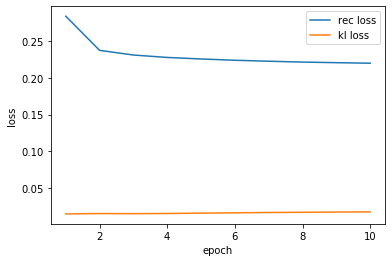

In [6]:
plt.plot(list(range(1, len(rec_losses)  + 1)), rec_losses, label="rec loss")
plt.plot(list(range(1, len(kl_losses)  + 1)), kl_losses, label="kl loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.plot()

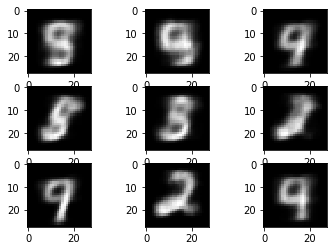

In [7]:
generator.eval()
samples = generator.generate(10).cpu().numpy()

fig, ax = plt.subplots(nrows=3, ncols=3)

for row in range(ax.shape[0]):
    for col in range(ax.shape[1]):
        img = samples[row + col * 3]
        ax[row][col].imshow(img.reshape((28, 28)), cmap="gray")

In [11]:
class CAE(nn.Module):
    """ Convolutional autoencoder, which will be used for denoising
    """
    def __init__(self, input_channels, lat_dim, device):
        super().__init__()
        self.conv1_ds = nn.Conv2d(input_channels, 32, kernel_size=(3, 3), stride=(2,2), padding=1)
        self.conv2_ds = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.dense_enc = nn.Linear(7 * 7 * 64, lat_dim)
        self.dense_dec = nn.Linear(lat_dim, 7 * 7 * 32)
        self.conv2_us = nn.ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.conv1_us = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.conv0_us = nn.ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=1)
        self.lat_dim = lat_dim
        self.device = device
        
    def encode(self, x):
        x = self.conv1_ds(x)
        x = nn.functional.relu(x)
        x = self.conv2_ds(x)
        x = nn.functional.relu(x)
        x = torch.flatten(x, 1)
        x = self.dense_enc(x)
        return x
        
    def decode(self, x):
        x = self.dense_dec(x)
        x = nn.functional.relu(x)
        x = torch.reshape(x, (x.shape[0], 32, 7, 7))
        x = self.conv2_us(x)
        x = nn.functional.relu(x)
        x = self.conv1_us(x)
        x = nn.functional.relu(x)
        x = self.conv0_us(x)
        # trick to make sure all outputs are in range [0, 1]
        x = torch.sigmoid(x)
        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [19]:
num_epochs = 5
bce_loss = torch.nn.BCELoss()
denoiser = CAE(1, 10, device).to(device)
optimizer = torch.optim.Adam(denoiser.parameters(), lr=1e-4)

losses = []
denoiser.train()
for epoch in range(1, num_epochs + 1):
    running_loss = 0
    iterations = 0
    for x, _ in ds_loader:
        x = x.to(device)
        noise = torch.rand_like(x).to(device)
        x_noisy = x.to(device) + 0.4 * noise
        optimizer.zero_grad()
        reconstruction = denoiser(x_noisy)
        reconstruction = reconstruction.view(x.shape[0], -1)
        x = x.view(x.shape[0], -1)
        loss = bce_loss(reconstruction, x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        iterations += 1
        
    loss = running_loss / iterations
    losses.append(rec_loss)
    print(f"Epoch {epoch}/{num_epochs} -- loss: {loss}")

Epoch 1/5 -- loss: 0.20555937465219
Epoch 2/5 -- loss: 0.1432095622197747
Epoch 3/5 -- loss: 0.13460246168785273
Epoch 4/5 -- loss: 0.1295208105173854
Epoch 5/5 -- loss: 0.12586841527951484


In [20]:
samples = torch.from_numpy(samples).to(device)

TypeError: expected np.ndarray (got Tensor)

In [21]:
denoiser.eval()
samples_denoised = denoiser(samples).detach().cpu().numpy()

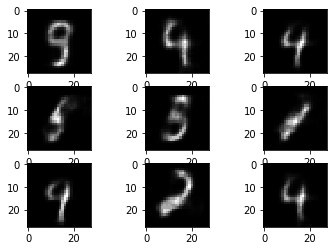

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3)

for row in range(ax.shape[0]):
    for col in range(ax.shape[1]):
        img = samples_denoised[row + col * 3]
        ax[row][col].imshow(img.reshape((28, 28)), cmap="gray")

In [ ]:
# HERE https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-cvae_no-out-concat.ipynb